# Dyson Brownian motion

## 1. Static DPP

In [1]:
%pylab inline
from numpy.matlib import repmat
import plotly.graph_objs as go
import plotly.offline
from matplotlib.gridspec import GridSpec
plt.style.use('classic')
plt.rc('figure',facecolor='w')
plt.rc('font', size=10)
from plot_tools import adjust_spines, sc_law, plot_dpp, plot_traj_with_histo, plot_traj_with_histo_sclaw

Populating the interactive namespace from numpy and matplotlib


In [4]:
def gue(dim, beta, normalization=False):
    """ GUE matrix used to generated the Hermitian Brownian motion as describe in agz
            parameters :
                - beta=1 for GOE et 2 for GUE
                - normalization=True if division by 1/sqrt(N) is wanted (in agz for example)
            """
    B = np.random.randn(dim, dim)
    B_tild = np.random.randn(dim, dim)
    diag = (2/(beta))**0.5 * np.diag(np.diag(B))
    triu = (1/(beta))**0.5 * (np.triu(B,1) + 1j*(beta-1)*np.triu(B_tild,1))
    H = np.zeros((dim,dim)) + diag + triu + np.conjugate(triu).T
    if normalization:
        H_return = (1/(dim**0.5))*H
    else:
        H_return = H
    return H_return

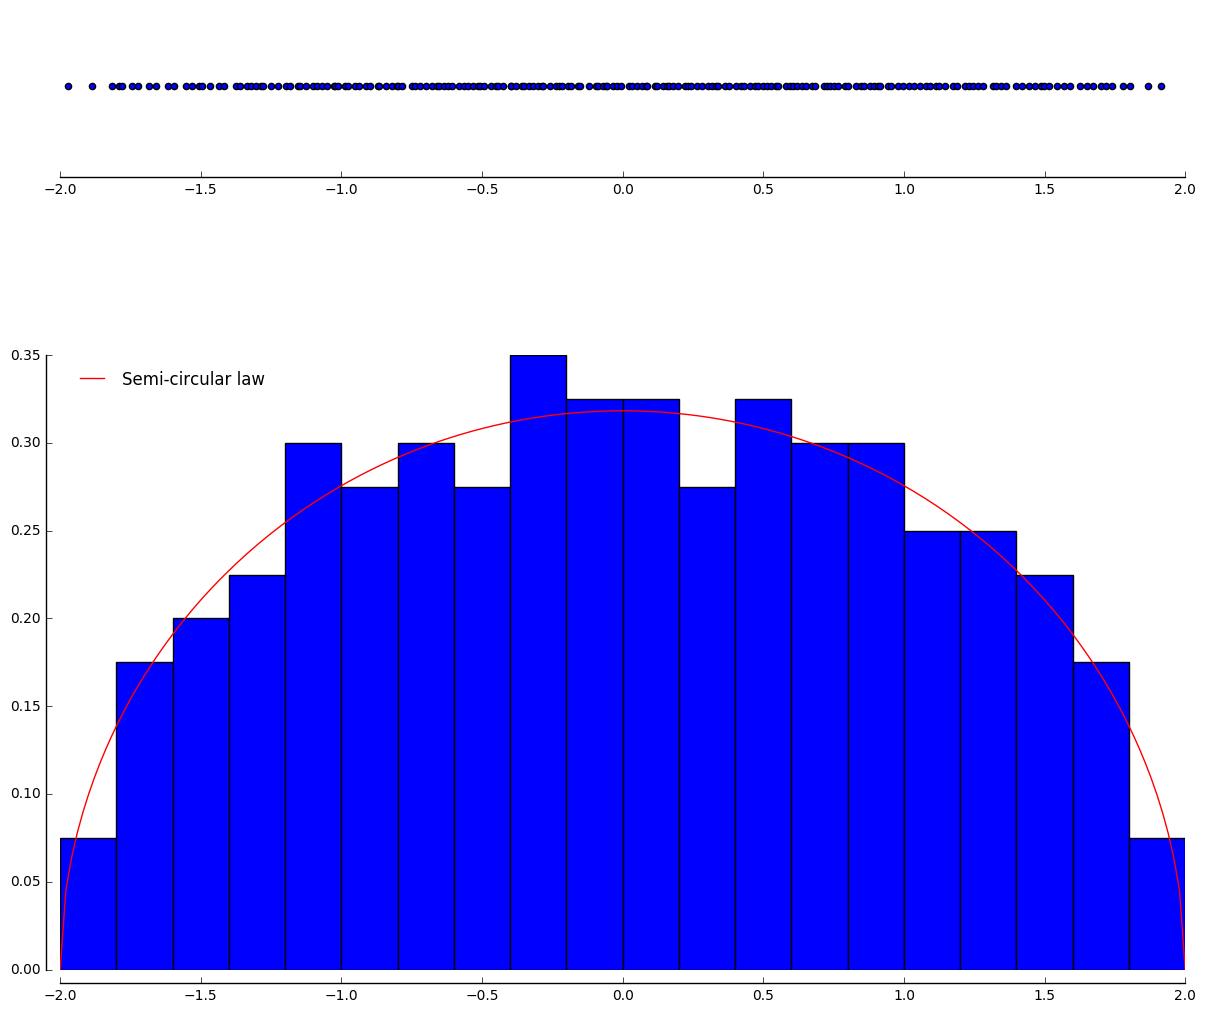

In [5]:
N=200
eigenvalues_samples = np.linalg.eigvalsh(gue(N, 2, normalization=True))

plot_dpp(eigenvalues_samples, './plot/gue_eigenvalues.png')

## 2. Classic Dyson Brownian motion

In [6]:
class dyson_brownian_motion:
    def __init__(self, n_traj, n_samples, tf, rescaling=False, init_mat=None):
        self.n_traj = n_traj
        self.n_samples = n_samples
        self.tf = tf
        self.rescaling = rescaling
        self.dt = tf/n_samples
        #init_mat = gue(self.n_traj, beta=2, normalization=True)
        if init_mat is None :
            init_mat = np.zeros((self.n_traj, self.n_traj))
        self.matrices = [init_mat]
        self.generate()
        self.eigen_values = [ sorted(np.linalg.eigvalsh(init_mat),reverse=True) ]
        self.diag()

    def generate(self):
        if self.rescaling:
            for sample in range(1, self.n_samples+1):
                self.matrices.append(self.matrices[sample-1] + gue(self.n_traj, beta=2, normalization=True)*(self.dt)**0.5)
        else:
            for sample in range(1, self.n_samples+1):
                self.matrices.append(self.matrices[sample-1] + gue(self.n_traj, beta=2, normalization=True)*(self.dt)**0.5)

    def diag(self):
        if self.rescaling:
            for sample in range(1, self.n_samples+1):
                eigen_values = sorted(np.linalg.eigvalsh(self.matrices[sample]), reverse=True)
                self.eigen_values.append ( 1/np.sqrt((sample)*self.dt)* np.array(eigen_values) ) 
        else:
            for sample in range(1, self.n_samples+1):
                self.eigen_values.append ( sorted(np.linalg.eigvalsh(self.matrices[sample]), reverse=True) )

In [7]:
dbm = dyson_brownian_motion(50, 300, 1, rescaling=False)
#dbm.plotly_plot()

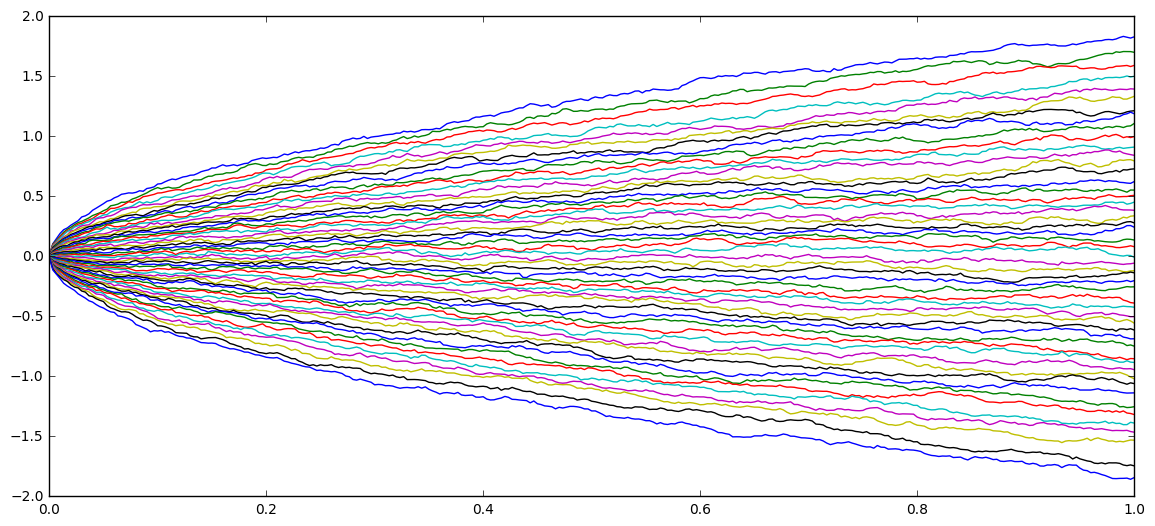

In [8]:
fig = plt.figure(1, figsize=(14, 6))

t = np.matlib.repmat(np.arange(0, dbm.tf+dbm.dt, dbm.dt), dbm.n_traj,1)
plt.plot(t.T, dbm.eigen_values)
plt.savefig('./plot/dyson_brownian_motion.png', bbox_inches='tight')

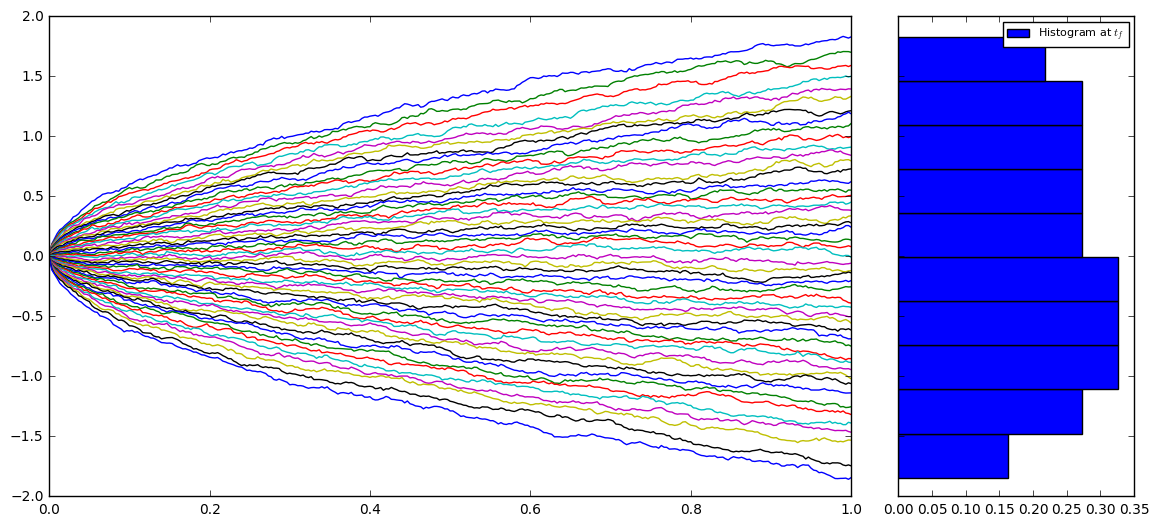

In [9]:
plot_traj_with_histo(dbm, './plot/dyson_brownian_motion_histo.png')

#### Rescaling

In [12]:
dbm_rescale = dyson_brownian_motion(n_traj=50, n_samples=300, tf=1, rescaling=True, init_mat=None)

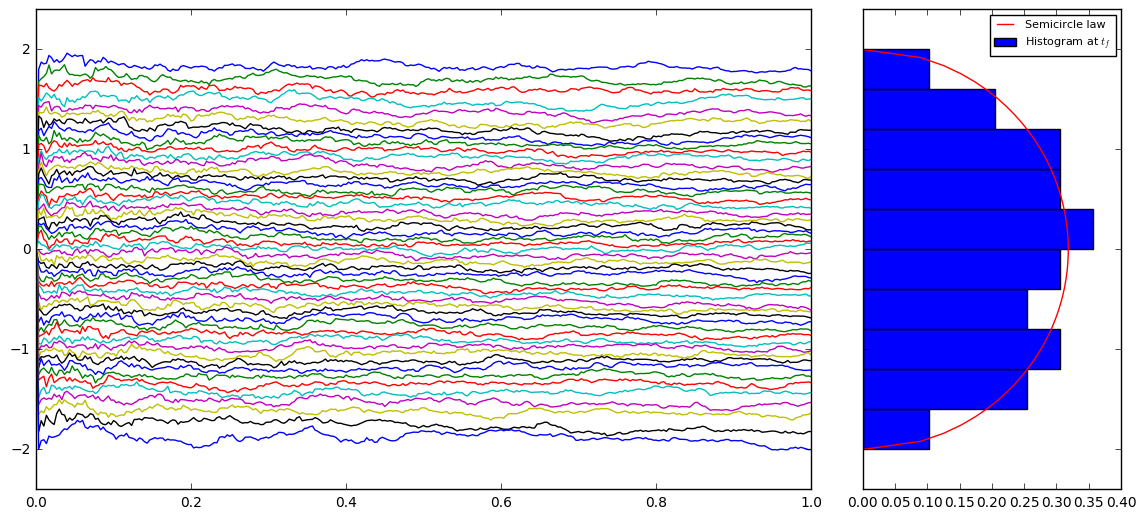

In [13]:
plot_traj_with_histo_sclaw(dbm_rescale, R=2, title='./plot/dyson_brownian_motion_rescaled.png')

## 4. Eigenvalues SDE

In [10]:
class dbm_eigen_values:
    def __init__(self, n_traj, n_samples, tf, rescaling=False):
        self.n_traj = n_traj
        self.n_samples = n_samples
        self.tf=tf
        self.dt = tf/n_samples
        self.eigen_values = np.zeros((self.n_samples+1, self.n_traj))
        self.rescaling = rescaling
        if self.rescaling:
            self.eigen_values_rescaled = np.zeros((self.n_samples+1, self.n_traj))
        self.initialisation()
        self.generate()

    def initialisation(self):
        self.eigen_values[0] = np.linspace(-0.5, 0.5, num=self.n_traj)
        #init_mat = gue(self.n_traj, beta=2, normalization=True)
        #init_mat = np.zeros((self.n_traj, self.n_traj))
        #self.eigen_values[0] = sorted(np.linalg.eigvalsh(init_mat),reverse=True)
        return self.eigen_values

    def generate(self):
        for sample in range(1, self.n_samples+1):
            
            for i in range(self.n_traj):

                lbda_i = self.eigen_values[sample-1][i]
                eigen_values_list = [lbda for lbda in list(self.eigen_values[sample-1]) if lbda != lbda_i]

                sum_term = sum ([ (1/(lbda_i - lbda_k)) for lbda_k in eigen_values_list ])

                W = (self.dt)**(0.5) * np.random.randn()
                
                self.eigen_values[sample][i] = self.eigen_values[sample-1][i] + \
                                                W *(1/self.n_traj)**(0.5) + \
                                                 (1/self.n_traj)*sum_term * self.dt
        if self.rescaling:
            for sample in range(1, self.n_samples+1):
                self.eigen_values[sample] = np.multiply(self.eigen_values[sample],1/np.sqrt(sample*self.dt))
                
        return self.eigen_values

In [11]:
n_traj = 60
n_samples = 3000
dbm_ev = dbm_eigen_values(n_traj, n_samples, 1,rescaling=False)

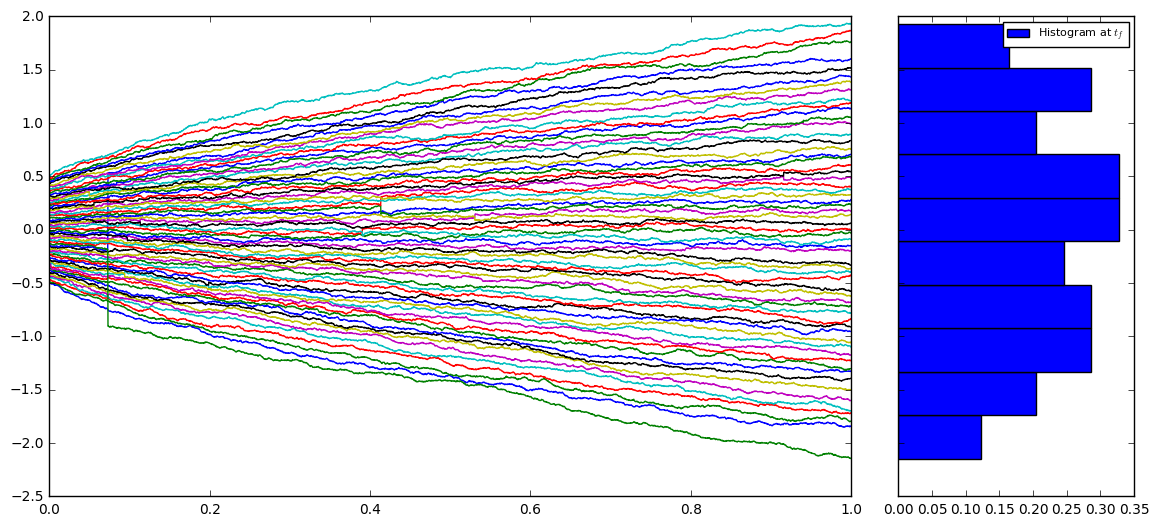

In [12]:
plot_traj_with_histo(dbm_ev, title='./plot/dbm_eigenvalues_'+str(n_traj)+'_'+str(n_samples)+'.png')

#### Rescaling

In [13]:
n_traj = 60
n_samples = 3000
dbm_ev_rescale = dbm_eigen_values(n_traj, n_samples, 1,rescaling=True)

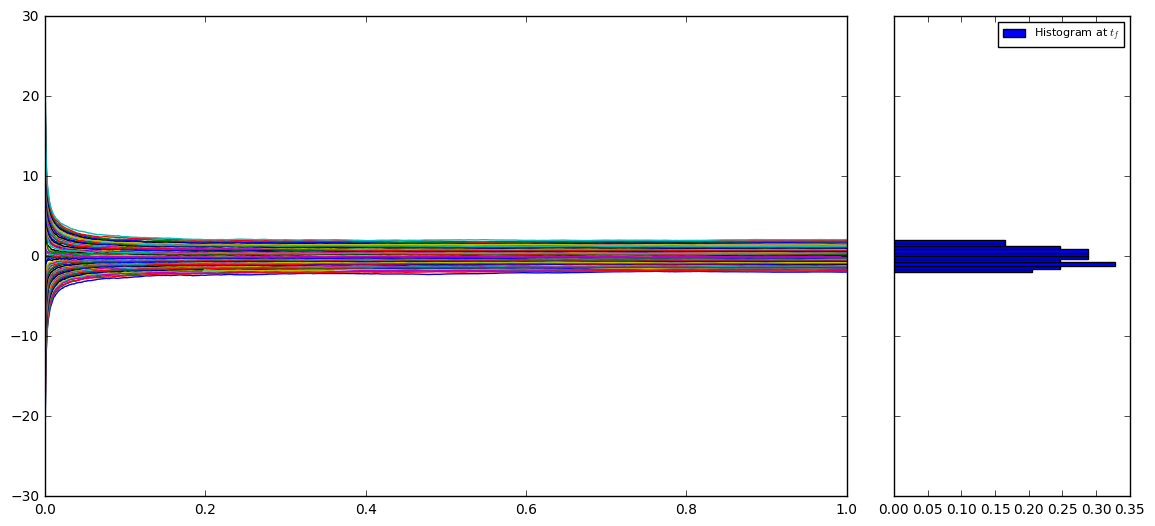

In [14]:
plot_traj_with_histo(dbm_ev_rescale, title='./plot/dbm_eigenvalues_rescale'+str(n_traj)+'_'+str(n_samples)+'.png')

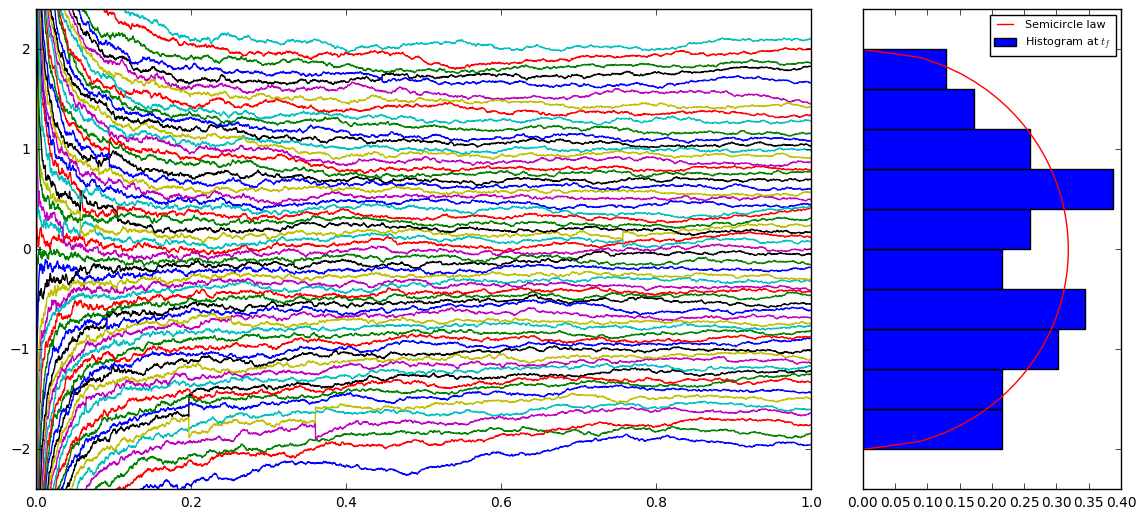

In [15]:
plot_traj_with_histo_sclaw(dbm_ev_rescale,R=2, title='./plot/dbm_eigenvalues_sclaw_rescale'+str(n_traj)+'_'+str(n_samples)+'.png')

#### Changement de temps

In [16]:
class dbm_eigen_values_time_change:
    def __init__(self, n_traj, n_samples, tf):
        self.n_traj = n_traj
        self.n_samples = n_samples
        self.tf=tf
        self.dt = tf/n_samples
        self.eigen_values = np.zeros((self.n_samples+1, self.n_traj))
        self.initialisation()
        self.generate()

    def initialisation(self):
        self.eigen_values[0] = np.linspace(-0.5, 0.5, num=self.n_traj)
        #init_mat = gue(self.n_traj, beta=2, normalization=True)
        #init_mat = np.zeros((self.n_traj, self.n_traj))
        #self.eigen_values[0] = sorted(np.linalg.eigvalsh(init_mat),reverse=True)
        return self.eigen_values

    def generate(self):
        for sample in range(1, self.n_samples+1):
            
            for i in range(self.n_traj):

                lbda_i = self.eigen_values[sample-1][i]
                eigen_values_list = [lbda for lbda in list(self.eigen_values[sample-1]) if lbda != lbda_i]

                sum_term = sum ([ (1/(lbda_i - lbda_k)) for lbda_k in eigen_values_list ])

                W = (self.dt)**(0.5) * np.random.randn()
                
                self.eigen_values[sample][i] = self.eigen_values[sample-1][i] + \
                                                W *(1/np.sqrt(self.n_traj*sample*self.dt)) + \
                                                 (1/self.n_traj*sample*self.dt)*sum_term * self.dt - \
                                                 (1/2*sample*self.dt)*self.eigen_values[sample-1][i] * self.dt
        return self.eigen_values

In [17]:
n_traj = 30
n_samples = 3000
dbm_ev_time_change = dbm_eigen_values_time_change(n_traj, n_samples, 1)

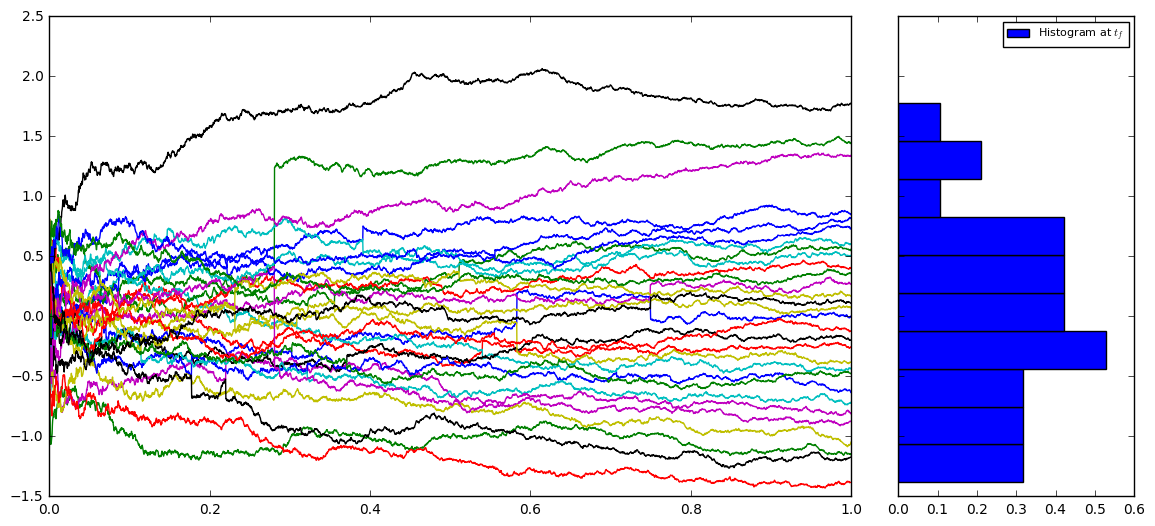

In [18]:
plot_traj_with_histo(dbm_ev_time_change, title='./plot/dbm_eigenvalues_rescale'+str(n_traj)+'_'+str(n_samples)+'.png')

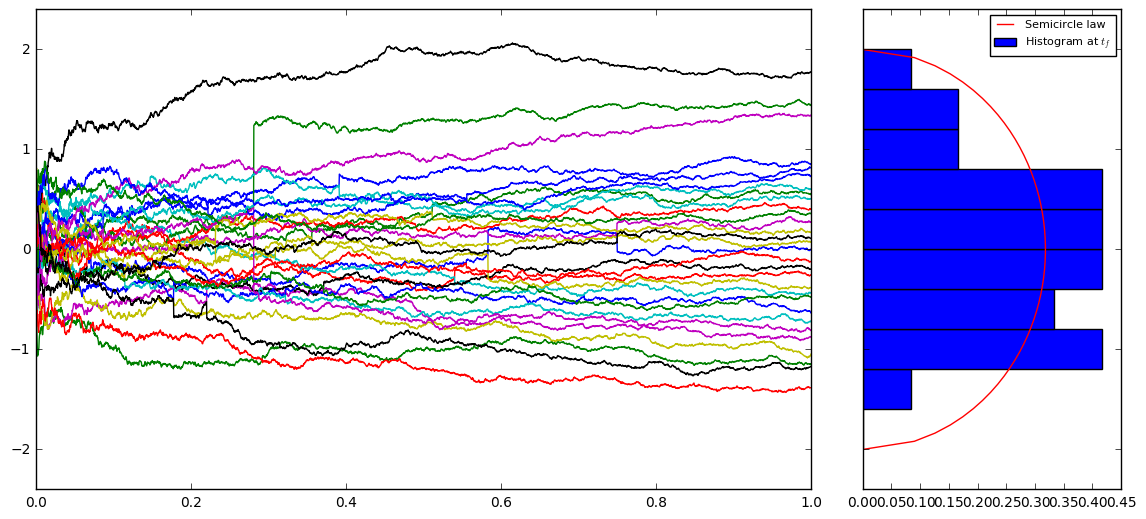

In [19]:
plot_traj_with_histo_sclaw(dbm_ev_time_change,R=2, title='./plot/dbm_eigenvalues_sclaw_rescale'+str(n_traj)+'_'+str(n_samples)+'.png')

In [ ]:
for i in 